In [2]:
import numpy as np
import numpy.ma as ma
import xarray as xr
from matplotlib import pyplot as plt
import seaborn as sns
import scipy
import scipy.stats as stats
import scipy.io as sio
from scipy.stats import norm, gamma
import pandas as pd
import datetime
import cartopy.crs as ccrs
import cartopy.feature as cfeature

%matplotlib inline

In [31]:
# load precip data
fpath = '/glade/work/vcooper/atms_552_objanalysis/hw3/'
file_precip = 'precip.V1.0.mon.mean2018.nc'
ds_precip = xr.open_dataset(fpath + file_precip).sel(time=slice('1950','2016')) # skip 1948 and 1949 due to weak data
nlon = len(ds_precip.lon)
nlat = len(ds_precip.lat)
nmonths = len(ds_precip.time)
print(nlat,nlon, nmonths)
ds_precip

120 300 804


<xarray.Dataset>
Dimensions:  (lat: 120, lon: 300, time: 804)
Coordinates:
  * lat      (lat) float32 20.125 20.375 20.625 20.875 ... 49.375 49.625 49.875
  * lon      (lon) float32 230.125 230.375 230.625 ... 304.375 304.625 304.875
  * time     (time) datetime64[ns] 1950-01-01 1950-02-01 ... 2016-12-01
Data variables:
    precip   (time, lat, lon) float32 ...
Attributes:
    title:          CPC Unified Gauge-Based Analysis of Daily Precipitation o...
    Conventions:    COARDS
    history:        created 05/2012 by CAS from data obtained at NOAA NCEP/CPC
    description:    CPC Unified Gauge-Based Analysis of Daily Precipitation o...
    platform:       Observations
    Comments:       Preciptation is accumulated from 12z of previous day to 1...
    References:     http://www.esrl.noaa.gov/psd/data/gridded/data.unified.da...
    dataset_title:  CPC Unified Gauge-Based Analysis of Daily Precipitation o...

In [4]:
# load el nino index data
file_enso = 'Nino_3-4.mat'
mat_enso = sio.loadmat(fpath + file_enso)
del mat_enso['__header__']
del mat_enso['__version__']
del mat_enso['__globals__']
print(mat_enso.keys())
mat_enso

dict_keys(['anom34', 'nino3', 'nino34', 'nino4', 'year'])


{'anom34': array([[-0.81],
        [-0.09],
        [ 0.88],
        [ 0.51],
        [-0.46],
        [-0.34],
        [ 0.31],
        [ 0.48],
        [ 0.47],
        [ 0.73],
        [ 0.39],
        [ 0.25],
        [ 0.15],
        [ 0.25],
        [ 0.19],
        [ 0.13],
        [-0.52],
        [-0.1 ],
        [ 0.34],
        [ 0.54],
        [ 0.45],
        [ 0.72],
        [ 0.77],
        [ 0.5 ],
        [ 0.09],
        [ 0.02],
        [ 0.12],
        [-0.23],
        [-0.44],
        [-0.51],
        [-0.26],
        [-0.01],
        [-0.41],
        [-0.01],
        [-0.56],
        [ 0.07],
        [ 0.32],
        [ 0.34],
        [ 0.53],
        [ 0.19],
        [ 0.04],
        [ 0.02],
        [-0.06],
        [ 0.03],
        [ 0.61],
        [ 0.13],
        [ 0.08],
        [ 0.1 ],
        [-0.3 ],
        [-0.2 ],
        [-0.37],
        [-1.34],
        [-1.  ],
        [-0.84],
        [-0.42],
        [-0.52],
        [-0.59],
        [-0.27],
    

In [5]:
# pull out arrays to eventually construct xarray dataset 
anom34 = np.array(mat_enso['anom34']).squeeze()
nino3 = np.array(mat_enso['nino3']).squeeze()
nino34 = np.array(mat_enso['nino34']).squeeze()
nino4 = np.array(mat_enso['nino4']).squeeze()
year = np.array(mat_enso['year']).squeeze()

# select only 804 months from 1950-01 to 2016-12 to match with precip data set
anom34 = anom34[0:len(anom34)-12]
nino3 = nino3[0:len(nino3)-12]
nino34 = nino34[0:len(nino34)-12]
nino4 = nino4[0:len(nino4)-12]
year = year[0:len(year)-12]

print(len(ds_precip.precip))
print(len(anom34), len(nino3), len(nino34), len(year))

804
804 804 804 804


In [6]:
# convert years to datetime object in enso index
time = np.zeros(len(year)).astype(str) # initialize empty array for dates
yeartemp = year-0.00001 # quick fix to get 12 data points per year

for i,yr in enumerate(yeartemp):
    Y = np.floor(yr).astype(int).astype(str)
    m = np.round((yr - np.floor(yr))*12,0).astype(int).astype(str)
    if len(m) < 2:
        m = '0' + m
    time[i] = Y + '-' + m + '-01' # artificially moves january
    
time

array(['1950-01-01', '1950-02-01', '1950-03-01', '1950-04-01',
       '1950-05-01', '1950-06-01', '1950-07-01', '1950-08-01',
       '1950-09-01', '1950-10-01', '1950-11-01', '1950-12-01',
       '1951-01-01', '1951-02-01', '1951-03-01', '1951-04-01',
       '1951-05-01', '1951-06-01', '1951-07-01', '1951-08-01',
       '1951-09-01', '1951-10-01', '1951-11-01', '1951-12-01',
       '1952-01-01', '1952-02-01', '1952-03-01', '1952-04-01',
       '1952-05-01', '1952-06-01', '1952-07-01', '1952-08-01',
       '1952-09-01', '1952-10-01', '1952-11-01', '1952-12-01',
       '1953-01-01', '1953-02-01', '1953-03-01', '1953-04-01',
       '1953-05-01', '1953-06-01', '1953-07-01', '1953-08-01',
       '1953-09-01', '1953-10-01', '1953-11-01', '1953-12-01',
       '1954-01-01', '1954-02-01', '1954-03-01', '1954-04-01',
       '1954-05-01', '1954-06-01', '1954-07-01', '1954-08-01',
       '1954-09-01', '1954-10-01', '1954-11-01', '1954-12-01',
       '1955-01-01', '1955-02-01', '1955-03-01', '1955-

In [7]:
nino34

array([-2.  , -1.68, -1.37, -1.43, -1.63, -1.13, -0.89, -0.95, -0.99,
       -0.98, -1.16, -1.27, -1.31, -1.03, -0.33, -0.13,  0.11,  0.14,
        0.42,  0.19,  0.5 ,  0.53,  0.63,  0.35,  0.12,  0.  , -0.06,
        0.09, -0.02, -0.41, -0.65, -0.54, -0.37, -0.41, -0.71, -0.35,
        0.19,  0.25,  0.34,  0.33,  0.47,  0.53,  0.25,  0.11,  0.28,
        0.2 ,  0.25,  0.44,  0.43,  0.29, -0.33, -1.06, -0.69, -0.79,
       -1.07, -1.41, -1.61, -1.44, -1.06, -1.3 , -0.94, -0.94, -1.01,
       -1.11, -1.15, -1.04, -1.03, -1.33, -1.44, -2.26, -2.37, -1.99,
       -1.21, -0.98, -0.78, -0.86, -0.68, -0.78, -0.95, -1.15, -0.99,
       -0.93, -1.07, -0.85, -0.51, -0.21,  0.22,  0.52,  0.74,  0.77,
        0.99,  0.86,  0.71,  0.74,  0.99,  1.34,  1.78,  1.5 ,  1.03,
        0.57,  0.5 ,  0.4 ,  0.14,  0.01, -0.33, -0.23,  0.13,  0.05,
        0.52,  0.44,  0.24,  0.17, -0.11, -0.22, -0.74, -0.74, -0.81,
       -0.43, -0.58, -0.38, -0.29, -0.45, -0.25, -0.22, -0.13, -0.35,
       -0.3 , -0.13,

In [8]:
## Create xarray for ENSO
data_vars = {'nino3': (['time'],nino3), 'nino4':(['time'],nino4), 'nino34':(['time'],nino34), 'anom34':(['time'],anom34)}
coords_time = {'time':time}
ds_enso = xr.Dataset(data_vars, coords=coords_time)
ds_enso

<xarray.Dataset>
Dimensions:  (time: 804)
Coordinates:
  * time     (time) <U32 '1950-01-01' '1950-02-01' ... '2016-11-01' '2016-12-01'
Data variables:
    nino3    (time) float64 -2.11 -1.52 -0.8 -1.04 ... -0.29 -0.54 -0.55 -0.44
    nino4    (time) float64 -1.3 -1.43 -1.68 -1.55 ... -0.14 -0.32 -0.32 -0.09
    nino34   (time) float64 -2.0 -1.68 -1.37 -1.43 ... -0.58 -0.69 -0.68 -0.47
    anom34   (time) float64 -0.81 -0.09 0.88 0.51 ... -0.15 -0.22 -0.23 -0.35

In [10]:
## setting up critical values and d.f. for significance testing
yrmx = int(len(ds_enso.time)/12) # number of years for d.f. determination; 1950 to 2016
print(yrmx)
alphaupper = 1-0.05/2 # 95% confidence level
tcrit = stats.t.ppf(alphaupper,yrmx) # critical value for two tailed test with d.f.
print(alphaupper, tcrit)

67
0.975 1.9960083534755055


In [11]:
# compute monthly climo of precip data with std
ds_precip_m = ds_precip.groupby('time.month',squeeze=False).mean(dim='time')
ds_precip_m = ds_precip_m.rename_vars(precip='m_mean')

ds_precip_d = ds_precip.groupby('time.month',squeeze=False).std(dim='time', ddof=1) # set d.f. to N-1
ds_precip_d = ds_precip_d.rename_vars(precip='stdev')

ds_precip_m = ds_precip_m.merge(ds_precip_d)
ds_precip_m

/gpfs/u/apps/dav/opt/python/3.6.8/gnu/7.3.0/pkg-library/20190723/lib/python3.6/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


<xarray.Dataset>
Dimensions:  (lat: 120, lon: 300, month: 12)
Coordinates:
  * lat      (lat) float32 20.125 20.375 20.625 20.875 ... 49.375 49.625 49.875
  * lon      (lon) float32 230.125 230.375 230.625 ... 304.375 304.625 304.875
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    m_mean   (month, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    stdev    (month, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan

## CHOOSE WHICH NINO INDEX HERE

In [16]:
# normalize nino data ## set up so that I can run with all nino
nino_data = ds_enso.nino34 #EDIT HERE

nino_mean = nino_data.mean() 
nino_std = nino_data.std(ddof=1) 
print(nino_mean, nino_std)

nino_norm = (nino_data-nino_mean)/nino_std 
print(nino_norm.mean(), nino_norm.std(ddof=1))

<xarray.DataArray 'nino34' ()>
array(-0.128632) <xarray.DataArray 'nino34' ()>
array(0.883485)
<xarray.DataArray 'nino34' ()>
array(-4.418798e-17) <xarray.DataArray 'nino34' ()>
array(1.)


In [28]:
# Create monthly lists of nino data
nino_mon = np.zeros(len(nino_data)).reshape(yrmx,12)

for i in range(0,12):
    nino_mon[:,i] = nino_norm[i::12] # gets every twelth element starting at ith element

nino_mon.shape

(67, 12)

# Normalize Precipitation Data

In [76]:
# Organize data by month to normalize by climatology
arr_precip_mon = np.zeros(nlat*nlon*nmonths).reshape(yrmx,12,nlat,nlon)
arr_norm_mon = np.zeros(nlat*nlon*nmonths).reshape(yrmx,12,nlat,nlon)

for i in range(0,12):
    arr_precip_mon[:,i,:,:] = ds_precip.precip[i::12].values # gets every twelth element starting at ith element

arr_precip_mon.shape

(67, 12, 120, 300)

In [80]:
# compute monthly climo of precip data with std
ds_precip_m = ds_precip.groupby('time.month',squeeze=False).mean(dim='time')
ds_precip_m = ds_precip_m.rename_vars(precip='m_mean')

ds_precip_d = ds_precip.groupby('time.month',squeeze=False).std(dim='time', ddof=1) # set d.f. to N-1
ds_precip_d = ds_precip_d.rename_vars(precip='stdev')

ds_precip_m = ds_precip_m.merge(ds_precip_d)
ds_precip_m

<xarray.Dataset>
Dimensions:  (lat: 120, lon: 300, month: 12)
Coordinates:
  * lat      (lat) float32 20.125 20.375 20.625 20.875 ... 49.375 49.625 49.875
  * lon      (lon) float32 230.125 230.375 230.625 ... 304.375 304.625 304.875
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    m_mean   (month, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
    stdev    (month, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan

In [78]:
## CONFIRMED THIS PRODUCES SAME RESULT AS GROUPBY ABOVE
# # create monthly climatology
# climo_mean = np.zeros(nlat*nlon*12).reshape(12,nlat,nlon)
# climo_sd = np.zeros(nlat*nlon*12).reshape(12,nlat,nlon)

# for i in range(0,nlat):
#     for j in range(0,nlon):
#         for m in range(0,12):
#             climo_mean[m,i,j] = np.nanmean(arr_precip_mon[:,m,i,j])
#             climo_sd[m,i,j] = np.nanstd(arr_precip_mon[:,m,i,j], ddof=1) # set d.f. to N-1

In [101]:
# create normalized precip array
arr_norm_mon = np.zeros(nlat*nlon*nmonths).reshape(yrmx,12,nlat,nlon)

for m in range(0,12):
    arr_norm_mon[:,m,:,:] = (arr_precip_mon[:,m,:,:] - ds_precip_m.m_mean[m,:,:].values)/(ds_precip_m.stdev[m,:,:].values)

arr_norm_mon.shape # normalized by month at each grid point

(67, 12, 120, 300)

## Regression Analysis

In [103]:
# looping over all of the lats and lons and months
# there is surely a more efficient way to do this but i am being careful

x = nino_mon[:,:] # years, months
y_norm = arr_norm_mon[:,:,:,:] # yrs,months,lat,lon -- normalized
y_precip = arr_precip_mon[:,:,:,:] # lat,lon,yrs,months -- original
slope = np.zeros(nlat*nlon*12*2).reshape(nlat,nlon,12,2)
intercept = np.zeros(nlat*nlon*12*2).reshape(nlat,nlon,12,2)
r_value = np.zeros(nlat*nlon*12*2).reshape(nlat,nlon,12,2)
p_value = np.zeros(nlat*nlon*12*2).reshape(nlat,nlon,12,2)
std_err = np.zeros(nlat*nlon*12*2).reshape(nlat,nlon,12,2)

for i in range(0,nlat): 
    for j in range(0,nlon): 
        for m in range(0,12): 
            slope[i,j,m,0], intercept[i,j,m,0], r_value[i,j,m,0], p_value[i,j,m,0], std_err[i,j,m,0] = stats.linregress(x[:,m], y_norm[:,m,i,j])
            slope[i,j,m,1], intercept[i,j,m,1], r_value[i,j,m,1], p_value[i,j,m,1], std_err[i,j,m,1] = stats.linregress(x[:,m], y_precip[:,m,i,j])


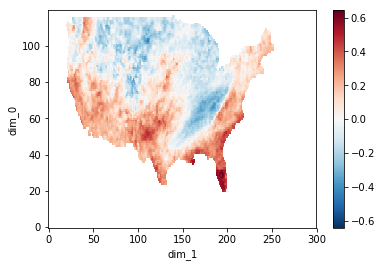

In [104]:
s_da = xr.DataArray(slope)
i_da = xr.DataArray(intercept)
r_da = xr.DataArray(r_value)
p_da = xr.DataArray(p_value)
se_da = xr.DataArray(std_err)

r_da[:,:,0,0].plot() # this matches DLH figure from Aodhan email

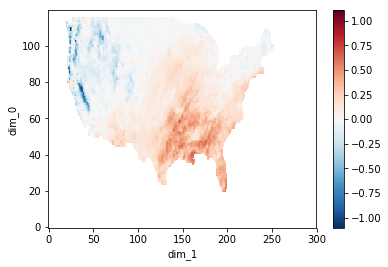

In [105]:
s_da[:,:,11,1].plot() # this matches DLH figure from email

# Maps with Correlation, Regression, Significance

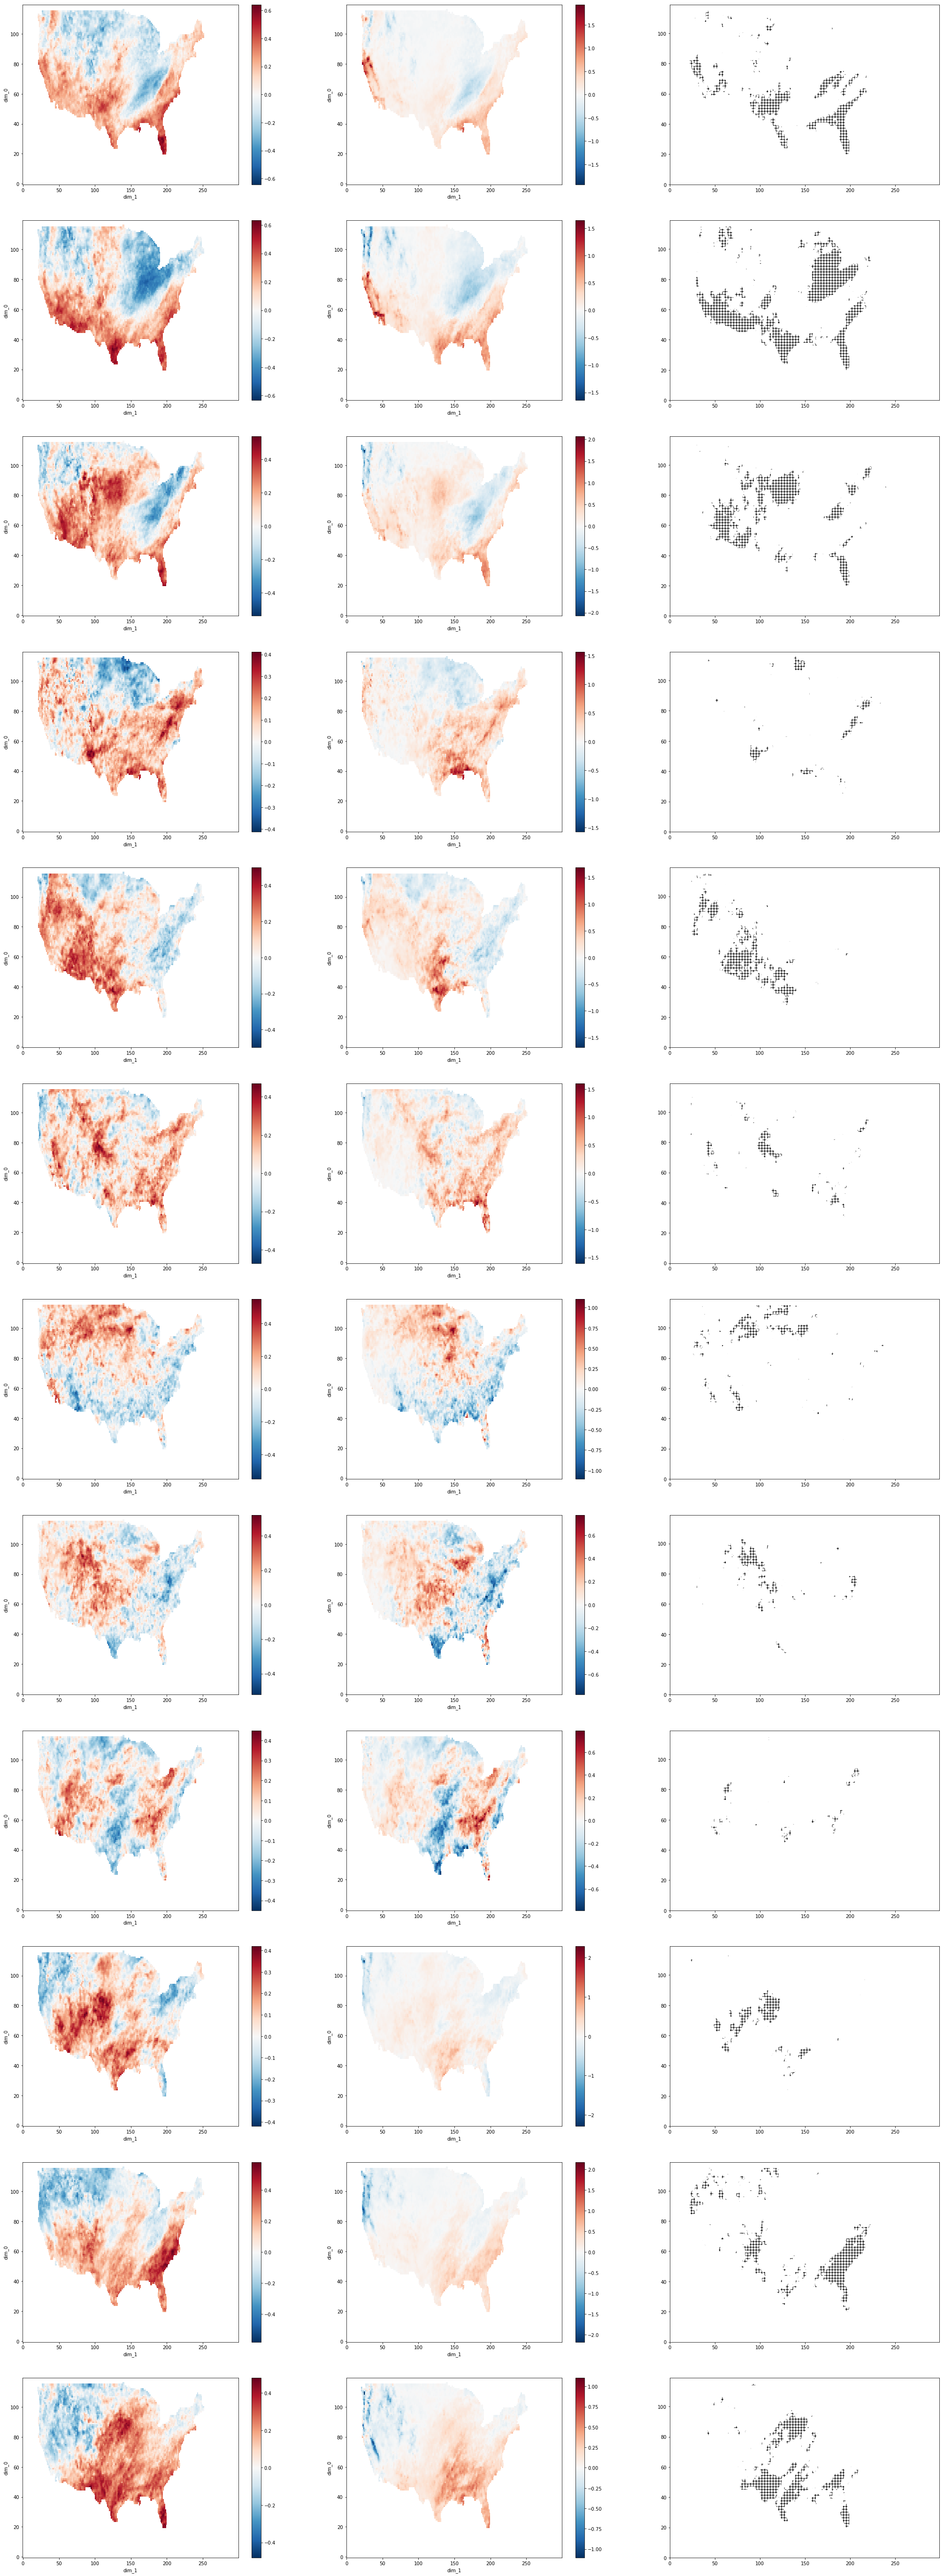

<Figure size 432x288 with 0 Axes>

In [108]:
fig, ax = plt.subplots(nrows=12, ncols=3, figsize=(35,100))

levels = [0,1-alphaupper] # contour settings for significance
colors = ['white','white'] # contour settings for significance

for i in range(0,12):
    r_da[:,:,i,0].plot(ax=ax[i,0])
    s_da[:,:,i,1].plot(ax=ax[i,1])
    ax[i,2].contourf(p_da.dim_1,p_da.dim_0,p_da[:,:,i,0], colors=colors, levels=levels, hatches=["++",""])
    
plt.show()
plt.tight_layout()

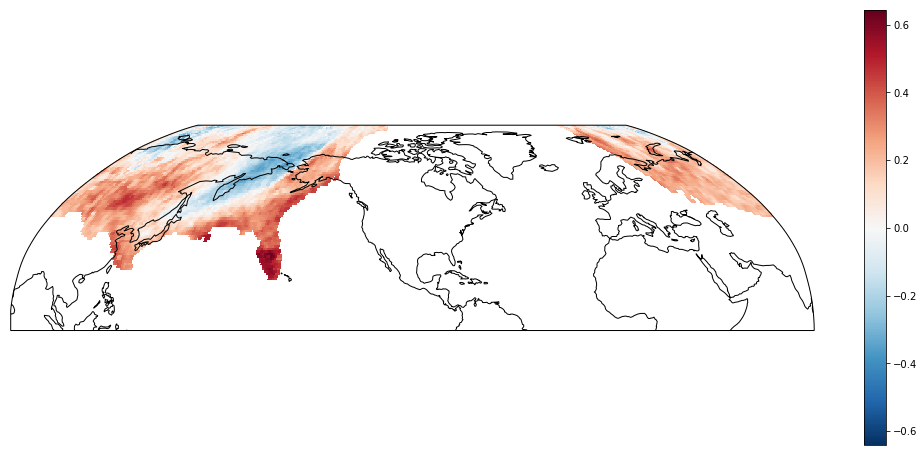

In [111]:
fig, ax = plt.subplots(figsize=(18,8))
ax = plt.axes(projection=ccrs.Robinson(260))
#ax.set_extent([230,300,23,50]) # x0,x1,y0,y1
ax.coastlines()
# ax.gridlines()
r_da[:,:,0,0].plot(ax=ax, transform=ccrs.PlateCarree())

In [ ]:
xr.Dataset({'pn': (['lat','lon','time'], arr_precip_norm)},
                    coords={'lat':lat, 'lon':lon, 'time':t})
dims = []